In [ ]:
!pip -q install ftfy regex tqdm git+https://github.com/openai/CLIP.git
!pip -q install kaggle scikit-learn pandas matplotlib

import os, shutil, zipfile, random, math, json
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import clip
from sklearn.metrics import accuracy_score, roc_auc_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


  Preparing metadata (setup.py) ... done
Device: cuda


In [ ]:

from google.colab import files

if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Upload kaggle.json (from Kaggle > Settings > Create New API Token)")
    uploaded = files.upload()  
    if 'kaggle.json' not in uploaded:
        raise RuntimeError("kaggle.json is required.")
    os.makedirs('/root/.kaggle', exist_ok=True)
    shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 0o600)

!kaggle datasets download -d nickfratto/pacs-dataset -p /content -q
!unzip -q -o /content/pacs-dataset.zip -d /content/


Dataset URL: https://www.kaggle.com/datasets/nickfratto/pacs-dataset
License(s): unknown


In [ ]:
def find_pacs_root(search_root="/content"):
    candidates = []
    for p in Path(search_root).rglob("pacs_label"):
        pr = p.parent
        if (pr/"pacs_data"/"pacs_data").exists():
            candidates.append(pr)
    if not candidates:
        raise FileNotFoundError("Could not find 'pacs/pacs_label' + 'pacs/pacs_data/pacs_data' under /content.")
    candidates = sorted(candidates, key=lambda x: len(str(x)))
    return candidates[0]

DATA_ROOT = find_pacs_root("/content")
IMG_ROOT = DATA_ROOT/"pacs_data"/"pacs_data"
LABEL_ROOT = DATA_ROOT/"pacs_label"
print("DATA_ROOT:", DATA_ROOT)
print("IMG_ROOT:", IMG_ROOT)
print("LABEL_ROOT:", LABEL_ROOT)


DATA_ROOT: /content
IMG_ROOT: /content/pacs_data/pacs_data
LABEL_ROOT: /content/pacs_label


In [ ]:
CLASS_NAMES = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]

def read_split(domain, split): 
    txt = LABEL_ROOT / f"{domain}_{split}_kfold.txt"
    items = []
    with open(txt, "r") as f:
        for line in f:
            rel, label = line.strip().split()
            label = int(label) - 1        
            p1 = DATA_ROOT/rel
            p2 = IMG_ROOT/rel
            p = p1 if p1.exists() else p2
            if not p.exists():
                p3 = IMG_ROOT/domain/Path(rel).name
                p = p3 if p3.exists() else p2
            items.append((str(p), label))
    return items

class ImageListDataset(Dataset):
    def __init__(self, listing, transform=None, max_per_class=None):
        self.samples = listing
        if max_per_class is not None:
            from collections import defaultdict
            buckets = defaultdict(list)
            for p,y in listing:
                buckets[y].append((p,y))
            self.samples = []
            for y, arr in buckets.items():
                self.samples.extend(arr[:max_per_class])
        self.transform = transform
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        p, y = self.samples[idx]
        img = Image.open(p).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, int(y), p


In [ ]:
model, preprocess = clip.load("ViT-B/16", device=device, jit=False)
logit_scale = model.logit_scale.exp().detach()

DOMAIN_TEMPLATES = {
    "photo": ["a photo of a {}.", "a photo of the {}."],
    "sketch": ["a sketch of a {}.", "a drawing of a {}."],
    "art_painting": ["a painting of a {}.", "a work of art of a {}."],
    "cartoon": ["a cartoon of a {}.", "a clipart of a {}."],
}
GENERIC_TEMPLATES = [
    "a photo of a {}.", "a drawing of a {}.", "a sketch of a {}.",
    "a painting of a {}.", "a cartoon of a {}."
]

@torch.no_grad()
def text_features_for_templates(classnames, templates):
    """
    Average CLIP text embeddings over a set of natural-language templates.
    """
    text_feats = []
    for cname in classnames:
        texts = [t.format(cname) for t in templates]
        tokens = clip.tokenize(texts).to(device)
        emb = model.encode_text(tokens)
        emb = emb / emb.norm(dim=-1, keepdim=True)
        text_feats.append(emb.mean(dim=0))
    text_feats = torch.stack(text_feats, dim=0)
    text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
    return text_feats  # (C, D)

@torch.no_grad()
def eval_zero_shot(dataloader, text_feats):
    correct, total = 0, 0
    for ims, ys, _ in dataloader:
        ims = ims.to(device)
        feats = model.encode_image(ims)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        logits = logit_scale * feats @ text_feats.T
        pred = logits.argmax(dim=-1).cpu().numpy()
        ys = ys.numpy()
        correct += (pred == ys).sum()
        total += ys.shape[0]
    return correct / max(total, 1)


In [ ]:
CONFIG = {
    "target_domain": "sketch",                      
    "source_domains": ["art_painting","cartoon","photo"],
    "batch_size": 32,   
    "num_workers": 2,
    "max_train_per_class": 120,   
    "max_test": None,             
    "epochs_linear": 8,           
    "epochs_prompt": 8,           
    "lr_linear": 2e-3,
    "lr_prompt": 5e-2,             
    "lambda_target_entropy": 0.2,  
    "seed": 42
}
random.seed(CONFIG["seed"]); np.random.seed(CONFIG["seed"]); torch.manual_seed(CONFIG["seed"])

In [ ]:
def make_loader(domain, split, batch_size, max_per_class=None, max_total=None, shuffle=False):
    listing = read_split(domain, split)
    if max_total is not None:
        listing = listing[:max_total]
    ds = ImageListDataset(listing, transform=preprocess, max_per_class=max_per_class)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle,
                      num_workers=CONFIG["num_workers"], pin_memory=True)


src_train_loaders = [make_loader(d, "train", CONFIG["batch_size"],
                                 max_per_class=CONFIG["max_train_per_class"], shuffle=True)
                     for d in CONFIG["source_domains"]]
tgt_train_loader = make_loader(CONFIG["target_domain"], "train",
                               CONFIG["batch_size"], max_per_class=CONFIG["max_train_per_class"], shuffle=True)
domain_test_loaders = {d: make_loader(d, "test", CONFIG["batch_size"], max_total=CONFIG["max_test"])
                       for d in DOMAINS}

def sanity_check(loader):
    ys = []
    for _, y, _ in loader:
        ys.extend(y.tolist())
        if len(ys) > 2000: break
    print("label min/max:", min(ys), max(ys))
for l in src_train_loaders: sanity_check(l)
sanity_check(domain_test_loaders[CONFIG["target_domain"]])


label min/max: 0 6
label min/max: 0 6
label min/max: 0 6
label min/max: 0 2


In [ ]:
zs_results = {}
for d in DOMAINS:
    templates = DOMAIN_TEMPLATES[d] + ["a photo of a {}."]  
    txt = text_features_for_templates(CLASS_NAMES, templates)
    acc = eval_zero_shot(domain_test_loaders[d], txt)
    zs_results[d] = acc

zs_df = pd.DataFrame({"domain": list(zs_results.keys()),
                      "zero_shot_acc": [zs_results[d] for d in zs_results]}).sort_values("domain")
zs_df


,domain,zero_shot_acc
0,art_painting,0.975586
1,cartoon,0.991468
2,photo,0.999401
3,sketch,0.894884


In [ ]:
@torch.no_grad()
def extract_features(dataloader):
    X, Y = [], []
    for ims, ys, _ in dataloader:
        ims = ims.to(device)
        feats = model.encode_image(ims)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        feats = feats.float()  # fp32
        X.append(feats.cpu())
        Y.append(ys.cpu())
    X = torch.cat(X, dim=0).float()
    Y = torch.cat(Y, dim=0).long()
    return X, Y

def normalize_labels(y_tensor, num_classes):
    """
    Make labels 0..(C-1). PACS kfold txts are often 1..C.
    If max label == num_classes, shift down by 1.
    """
    y = y_tensor.clone().long()
    if y.max().item() == num_classes:   
        y = y - 1
    assert y.min().item() >= 0 and y.max().item() <= num_classes-1, \
        f"Labels out of range after normalization: [{y.min().item()}, {y.max().item()}], C={num_classes}"
    return y

Xs, Ys = [], []
for l in src_train_loaders:
    X, Y = extract_features(l)
    Xs.append(X); Ys.append(Y)
X_src = torch.cat(Xs, dim=0).float()
y_src = torch.cat(Ys, dim=0)

num_classes = len(CLASS_NAMES)
feat_dim = X_src.shape[1]

y_src = normalize_labels(y_src, num_classes)

class LinearHead(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes, bias=False)
    def forward(self, x):
        return self.fc(x)

head = LinearHead(feat_dim, num_classes).to(device).float()
opt = torch.optim.Adam(head.parameters(), lr=CONFIG["lr_linear"], weight_decay=1e-4)

ds = torch.utils.data.TensorDataset(X_src, y_src)
dl = DataLoader(ds, batch_size=128, shuffle=True)

for epoch in range(CONFIG["epochs_linear"]):
    for xb, yb in dl:
        xb = xb.to(device).float()
        yb = yb.to(device).long()          
        logits = head(xb)
        loss = nn.CrossEntropyLoss()(logits, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
    if epoch % 2 == 0:
        print(f"[Linear] epoch {epoch+1}/{CONFIG['epochs_linear']}  loss={loss.item():.4f}")

@torch.no_grad()
def eval_with_head(head, loader, num_classes):
    preds, gts = [], []
    for ims, ys, _ in loader:
        ims = ims.to(device)
        xf = model.encode_image(ims)
        xf = xf / xf.norm(dim=-1, keepdim=True)
        xf = xf.float()
        logits = head(xf)
        pred = logits.argmax(dim=-1).cpu().numpy()
        gt = normalize_labels(ys.cpu(), num_classes).numpy()
        preds.extend(pred)
        gts.extend(gt)
    from sklearn.metrics import accuracy_score
    return accuracy_score(gts, preds)

target_test_loader = domain_test_loaders[CONFIG["target_domain"]]
acc_linear_tgt = eval_with_head(head, target_test_loader, num_classes)
acc_linear_tgt

[Linear] epoch 1/8  loss=1.7628
[Linear] epoch 3/8  loss=1.4319
[Linear] epoch 5/8  loss=1.1106
[Linear] epoch 7/8  loss=0.8994


0.8976838890302876

In [10]:
print("y_src min/max BEFORE:", int(y_src.min()), int(y_src.max()))


y_src min/max BEFORE: 0 6


In [ ]:
with torch.no_grad():
    TEXT_BANK = text_features_for_templates(CLASS_NAMES, GENERIC_TEMPLATES)  
@torch.no_grad()
def text_bank_all_templates(classnames, templates):
    all_cls = []
    for cname in classnames:
        texts = [t.format(cname) for t in templates]
        toks = clip.tokenize(texts).to(device)
        emb = model.encode_text(toks)
        emb = emb / emb.norm(dim=-1, keepdim=True)  
        all_cls.append(emb)
    return torch.stack(all_cls, dim=0)

with torch.no_grad():
    T_bank = text_bank_all_templates(CLASS_NAMES, GENERIC_TEMPLATES) 
C, M, D = T_bank.shape
T_bank = T_bank.to(device)

def infinite(loader):
    while True:
        for b in loader:
            yield b

src_iters = [infinite(l) for l in src_train_loaders]
tgt_iter = infinite(tgt_train_loader)


In [ ]:

import os
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")

class PromptWeights(nn.Module):
    def __init__(self, C, M):
        super().__init__()
        self.alpha = nn.Parameter(torch.zeros(C, M))  
    def prototypes(self, T_bank):
        w = torch.softmax(self.alpha, dim=-1).float()        
        proto = torch.einsum("cm,cmd->cd", w, T_bank.float())  
        proto = proto / proto.norm(dim=-1, keepdim=True)
        return proto.float()

def logits_from_prototypes(ims, protos):
    with torch.no_grad():
        feats = model.encode_image(ims)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        feats = feats.float()
    protos = protos.float()
    return (logit_scale.float()) * (feats @ protos.T)

def entropy_from_logits(logits):
    p = torch.softmax(logits, dim=-1)
    return -(p * (p.clamp_min(1e-8).log())).sum(dim=-1).mean()

with torch.no_grad():
    T_bank = T_bank.float().to(device)

pw = PromptWeights(C=C, M=M).to(device)
opt = torch.optim.Adam(pw.parameters(), lr=CONFIG["lr_prompt"])

grad_sims = []   

def grad_cosine(g1, g2):
    g1f = torch.cat([g.view(-1) for g in g1 if g is not None])
    g2f = torch.cat([g.view(-1) for g in g2 if g is not None])
    denom = (g1f.norm()*g2f.norm()).clamp_min(1e-12)
    return (g1f @ g2f / denom).item()

src_rr = list(range(len(src_iters)))
rr_idx = 0

PROMPT_BATCH_CAP = None  

for epoch in range(CONFIG["epochs_prompt"]):
    steps = min(*[len(l) for l in src_train_loaders]) 
    for step in range(steps):
        si = src_rr[rr_idx]
        rr_idx = (rr_idx + 1) % len(src_rr)

        ims_s, ys_s, _ = next(src_iters[si])
        imt, _, _ = next(tgt_iter)

        if PROMPT_BATCH_CAP is not None:
            ims_s = ims_s[:PROMPT_BATCH_CAP]
            ys_s  = ys_s[:PROMPT_BATCH_CAP]
            imt   = imt[:PROMPT_BATCH_CAP]

        ims_s = ims_s.to(device, non_blocking=True)
        ys_s  = ys_s.to(device, non_blocking=True).long()   
        imt   = imt.to(device, non_blocking=True)

        protos = pw.prototypes(T_bank)

        opt.zero_grad(set_to_none=True)
        logits_s = logits_from_prototypes(ims_s, protos)   
        loss_s = nn.CrossEntropyLoss()(logits_s, ys_s)
        g_s = torch.autograd.grad(loss_s, pw.parameters(), retain_graph=True, allow_unused=True)

        logits_t = logits_from_prototypes(imt, protos)
        loss_t = entropy_from_logits(logits_t)
        loss_u = CONFIG["lambda_target_entropy"] * loss_t
        g_t = torch.autograd.grad(loss_u, pw.parameters(), retain_graph=True, allow_unused=True)

        grad_sims.append(grad_cosine(g_s, g_t))

        total_loss = loss_s + loss_u
        opt.zero_grad(set_to_none=True)
        total_loss.backward()
        opt.step()

        del ims_s, ys_s, imt, logits_s, logits_t, loss_s, loss_t, loss_u, total_loss, protos
        torch.cuda.empty_cache()

    print(f"[Prompt] epoch {epoch+1}/{CONFIG['epochs_prompt']}  "
          f"mean_grad_cos={np.mean(grad_sims[-steps:]):.3f}")


[Prompt] epoch 1/8  mean_grad_cos=-0.072
[Prompt] epoch 2/8  mean_grad_cos=-0.135
[Prompt] epoch 3/8  mean_grad_cos=-0.058
[Prompt] epoch 4/8  mean_grad_cos=-0.007
[Prompt] epoch 5/8  mean_grad_cos=0.017
[Prompt] epoch 6/8  mean_grad_cos=-0.149
[Prompt] epoch 7/8  mean_grad_cos=-0.038
[Prompt] epoch 8/8  mean_grad_cos=0.013


In [ ]:
@torch.no_grad()
def eval_with_prototypes(loader, prototypes):
    preds, gts = [], []
    for ims, ys, _ in loader:
        ims = ims.to(device)
        logits = logits_from_prototypes(ims, prototypes)
        preds.extend(logits.argmax(dim=-1).cpu().numpy())
        gts.extend(ys.numpy())
    return accuracy_score(gts, preds)

with torch.no_grad():
    tuned_protos = pw.prototypes(T_bank)

acc_prompt_tgt = eval_with_prototypes(domain_test_loaders[CONFIG["target_domain"]], tuned_protos)
acc_prompt_tgt


0.8987019597862052

In [ ]:
def pcgrad_merge(g1, g2):
    merged = []
    for a, b in zip(g1, g2):
        if a is None or b is None:
            merged.append(a if b is None else b)
            continue
        a = a.detach(); b = b.detach()
        dot = (a*b).sum()
        if dot < 0:
            bnorm2 = (b*b).sum().clamp_min(1e-12)
            a = a - dot/ bnorm2 * b
        merged.append(0.5*(a + b))
    return merged

for step in range( min(*[len(l) for l in src_train_loaders]) ):
    ims_s_list, ys_s_list = [], []
    for it in src_iters:
        ims, ys, _ = next(it)
        ims_s_list.append(ims); ys_s_list.append(ys)
    ims_s = torch.cat(ims_s_list, dim=0).to(device)
    ys_s = torch.cat(ys_s_list, dim=0).to(device)
    imt, _, _ = next(tgt_iter)
    imt = imt.to(device)

    protos = pw.prototypes(T_bank)

    opt.zero_grad(set_to_none=True)
    logits_s = logits_from_prototypes(ims_s, protos)
    loss_s = nn.CrossEntropyLoss()(logits_s, ys_s)
    g_s = torch.autograd.grad(loss_s, pw.parameters(), retain_graph=True, allow_unused=True)

    logits_t = logits_from_prototypes(imt, protos)
    loss_t = entropy_from_logits(logits_t)
    g_t = torch.autograd.grad(CONFIG["lambda_target_entropy"]*loss_t, pw.parameters(), allow_unused=True)

    g_m = pcgrad_merge(g_s, g_t)
    with torch.no_grad():
        for p, g in zip(pw.parameters(), g_m):
            if g is not None:
                p.grad = g.clone()
        opt.step()

with torch.no_grad():
    tuned_protos_pcgrad = pw.prototypes(T_bank)

acc_prompt_pcgrad_tgt = eval_with_prototypes(domain_test_loaders[CONFIG["target_domain"]], tuned_protos_pcgrad)
acc_prompt_pcgrad_tgt


0.897938406719267

Mean cosine similarity: -0.05346122366016196
Median cosine similarity: -0.040955912321805954
Conflict ratio (cos<=0): 0.5648148148148148


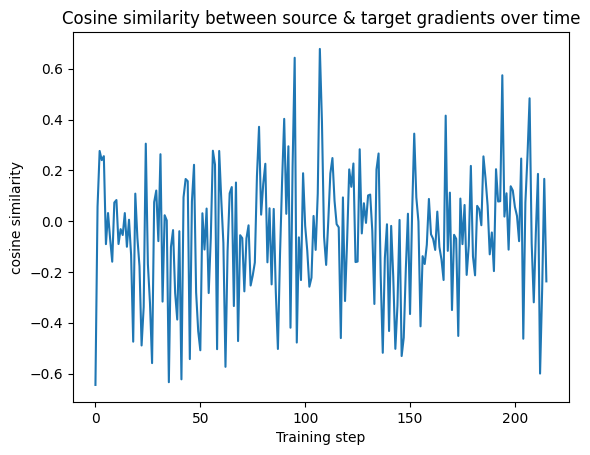

In [ ]:
import matplotlib.pyplot as plt
arr = np.array(grad_sims, dtype=float)
conflict_ratio = float((arr <= 0).mean())
print("Mean cosine similarity:", arr.mean())
print("Median cosine similarity:", np.median(arr))
print("Conflict ratio (cos<=0):", conflict_ratio)

plt.figure()
plt.plot(arr)
plt.title("Cosine similarity between source & target gradients over time")
plt.xlabel("Training step"); plt.ylabel("cosine similarity")
plt.show()


In [ ]:
seen_classes = ["dog","elephant","giraffe","guitar","horse","house"]  # 6 seen
unseen_classes = [c for c in CLASS_NAMES if c not in seen_classes]
print("Seen:", seen_classes)
print("Unseen:", unseen_classes)

seen_idx = [CLASS_NAMES.index(c) for c in seen_classes]
unseen_idx = [CLASS_NAMES.index(c) for c in unseen_classes]


Seen: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house']
Unseen: ['person']


In [ ]:
@torch.no_grad()
def msp_scores(loader, protos, restrict_to_classes):
    mask = torch.tensor(restrict_to_classes, device=device)
    scores, labels = [], []
    for ims, ys, _ in loader:
        ims = ims.to(device)
        ys = ys.numpy()
        logits = logits_from_prototypes(ims, protos) 
        logits = logits[:, mask] 
        p = torch.softmax(logits, dim=-1)
        msp = p.max(dim=-1).values.detach().cpu().numpy()
        scores.extend(msp)
        labels.extend((np.isin(ys, restrict_to_classes)).astype(int))  
    return np.array(scores), np.array(labels)

zs_proto_tgt = text_features_for_templates(CLASS_NAMES, DOMAIN_TEMPLATES[CONFIG["target_domain"]] + ["a photo of a {}."]).to(device)

scores_zs, labels_os = msp_scores(domain_test_loaders[CONFIG["target_domain"]], zs_proto_tgt, seen_idx)
scores_tuned, _ = msp_scores(domain_test_loaders[CONFIG["target_domain"]], tuned_protos, seen_idx)

def auroc(scores, labels):
    try:
        return roc_auc_score(labels, scores)
    except:
        return float("nan")

auroc_zs = auroc(scores_zs, labels_os)
auroc_tuned = auroc(scores_tuned, labels_os)

print("Open-set AUROC (higher better):")
print("  Zero-shot:", auroc_zs)
print("  Tuned prompt:", auroc_tuned)


Open-set AUROC (higher better):
  Zero-shot: 0.9768240912708942
  Tuned prompt: 0.9708891615813213


In [ ]:
@torch.no_grad()
def eval_seen_accuracy(loader, protos, seen_idxs):
    preds, gts = [], []
    mask = torch.tensor(seen_idxs, device=device)
    for ims, ys, _ in loader:
        ims = ims.to(device)
        logits = logits_from_prototypes(ims, protos)
        logits = logits[:, mask]
        pred_seen = logits.argmax(dim=-1).cpu().numpy()
        gt_seen_mask = np.isin(ys.numpy(), seen_idxs)
        preds.extend(pred_seen[gt_seen_mask])
        gts.extend(np.searchsorted(seen_idxs, ys.numpy()[gt_seen_mask])) 
    if len(gts)==0: return float("nan")
    return accuracy_score(gts, preds)

acc_seen_zs = eval_seen_accuracy(target_test_loader, zs_proto_tgt, seen_idx)
acc_seen_tuned = eval_seen_accuracy(target_test_loader, tuned_protos, seen_idx)
print("Seen-class accuracy on target:")
print("  Zero-shot:", acc_seen_zs)
print("  Tuned prompt:", acc_seen_tuned)


Seen-class accuracy on target:
  Zero-shot: 0.8928097638630936
  Tuned prompt: 0.8975855664632528


In [ ]:

K = 3  

def fewshot_target_loader(domain, k_per_class):
    listing = read_split(domain, "train")
    by_class = {c: [] for c in range(len(CLASS_NAMES))}
    for p,y in listing:
        if len(by_class[y]) < k_per_class:
            by_class[y].append((p,y))
        if all(len(by_class[c])>=k_per_class for c in by_class):
            break
    tiny = []
    for li in by_class.values(): tiny.extend(li)
    ds = ImageListDataset(tiny, transform=preprocess)
    return DataLoader(ds, batch_size=32, shuffle=True, num_workers=2)

few_loader = fewshot_target_loader(CONFIG["target_domain"], K)

pw_tgt = PromptWeights(C, M).to(device)
pw_tgt.alpha.data.copy_(pw.alpha.data)  
opt2 = torch.optim.Adam(pw_tgt.parameters(), lr=CONFIG["lr_prompt"])

for e in range(3):
    for ims, ys, _ in few_loader:
        ims, ys = ims.to(device), ys.to(device)
        protos = pw_tgt.prototypes(T_bank)
        logits = logits_from_prototypes(ims, protos)
        loss = nn.CrossEntropyLoss()(logits, ys)
        opt2.zero_grad(set_to_none=True); loss.backward(); opt2.step()
    print(f"[few-shot] epoch {e+1}/3 loss={loss.item():.3f}")

with torch.no_grad():
    protos_src = pw.prototypes(T_bank)           
    protos_few = pw_tgt.prototypes(T_bank)        

sims = torch.sum(protos_src * protos_few, dim=-1).cpu().numpy()
pd.DataFrame({"class": CLASS_NAMES, "cosine_sim_source_vs_fewshot": sims})


[few-shot] epoch 1/3 loss=0.053
[few-shot] epoch 2/3 loss=0.048
[few-shot] epoch 3/3 loss=0.045


,class,cosine_sim_source_vs_fewshot
0,dog,0.999795
1,elephant,0.999605
2,giraffe,0.999893
3,guitar,0.999580
4,horse,0.999577
5,house,0.999679
6,person,0.999815


In [ ]:
summary = {
 "zero_shot_photo": zs_results.get("photo", np.nan),
 "zero_shot_art":   zs_results.get("art_painting", np.nan),
 "zero_shot_cartoon": zs_results.get("cartoon", np.nan),
 "zero_shot_sketch": zs_results.get("sketch", np.nan),
 "linear_target_acc": acc_linear_tgt,
 "prompt_target_acc": acc_prompt_tgt,
 "prompt_pcgrad_target_acc": acc_prompt_pcgrad_tgt if 'acc_prompt_pcgrad_tgt' in globals() else np.nan,
 "open_set_auroc_zero_shot": auroc_zs,
 "open_set_auroc_tuned": auroc_tuned,
 "mean_grad_cos": float(np.mean(grad_sims)) if len(grad_sims) else np.nan,
 "conflict_ratio": float((np.array(grad_sims)<=0).mean()) if len(grad_sims) else np.nan,
}
pd.DataFrame([summary])


,zero_shot_photo,zero_shot_art,zero_shot_cartoon,zero_shot_sketch,linear_target_acc,prompt_target_acc,prompt_pcgrad_target_acc,open_set_auroc_zero_shot,open_set_auroc_tuned,mean_grad_cos,conflict_ratio
0,0.999401,0.975586,0.991468,0.894884,0.897684,0.898702,0.897938,0.976824,0.970889,-0.053461,0.564815
